In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.spatial import Voronoi
from typing import List, Dict, Any, Tuple
from shapely.geometry import MultiPoint, box
from shapely.ops import voronoi_diagram

In [2]:
# Simulation parameters
STEP_COUNT = 120            # Number of simulation frames (total steps in animation)
ANIMATION_INTERVAL = 150    # Delay between frames in milliseconds (controls animation speed)

# Field
FIELD_SIZE = (100, 100)

SEED_SPAWN_AREA = {
    "x": (20, 80),          # Horizontal spawn range for static seed points
    "y": (20, 80),          # Vertical spawn range for static seed points
}
NUM_POINTS = 7              # Number of static seed points (used for Voronoi diagram generation)

# Robot Swarm
ROBOT_SPAWN_AREA = {
    "x": (20, 80),          # Horizontal spawn range for robots
    "y": (20, 80),          # Vertical spawn range for robots
}
NUM_ROBOTS = 30             # Total number of robots in the swarm
SENSING_RADIUS = 20.0       # Radius within which robots can sense neighbors and seed points
SPEED = 1.0                 # Movement step size per simulation iteration

## Spawn Seeds

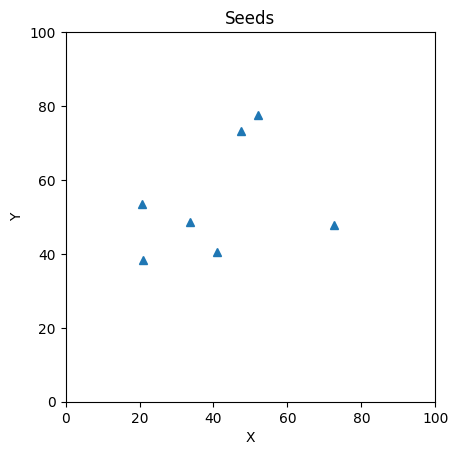

In [3]:
def spawn_points(n: int, bounds: dict[str, tuple[int, int]]) -> np.ndarray:
    """Spawn `n` random points within the specified bounds."""
    xs = np.random.uniform(bounds["x"][0], bounds["x"][1], size=n)
    ys = np.random.uniform(bounds["y"][0], bounds["y"][1], size=n)
    return np.c_[xs, ys]

seed_coords = spawn_points(NUM_POINTS, SEED_SPAWN_AREA)

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0]); ax.set_ylim(0, FIELD_SIZE[1]); ax.set_aspect("equal")
ax.set_title("Seeds")
ax.set_xlabel("X"); ax.set_ylabel("Y")
ax.plot(seed_coords[:,0], seed_coords[:,1], '^', linestyle='None')
plt.show()

## Spawn Robots

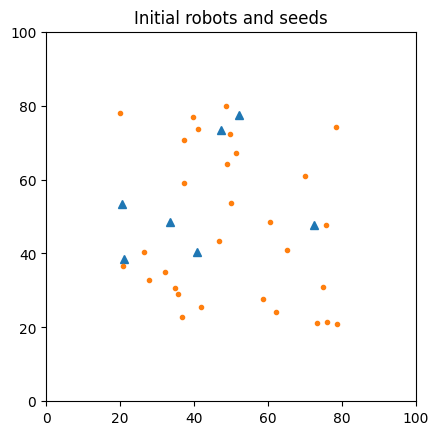

In [4]:
robot_coords = spawn_points(NUM_ROBOTS, ROBOT_SPAWN_AREA)

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0]); ax.set_ylim(0, FIELD_SIZE[1]); ax.set_aspect("equal")
ax.set_title("Initial robots and seeds")
ax.plot(seed_coords[:,0], seed_coords[:,1], '^', linestyle='None')
ax.plot(robot_coords[:,0], robot_coords[:,1], 'o', markersize=3)
plt.show()

## Sensing

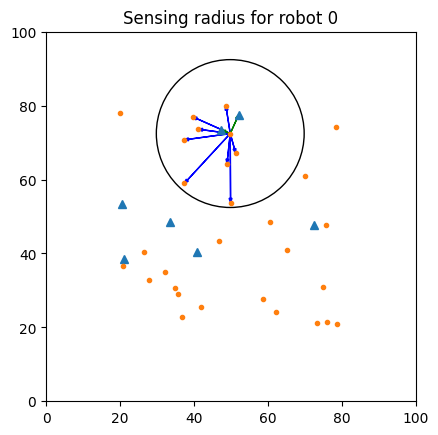

In [5]:
def sensor(
    robot_coords: np.ndarray,
    seed_coords: np.ndarray,
    sensing_radius: float
) -> List[Dict[str, List[Dict[str, Any]]]]:
    num_robots = len(robot_coords)
    results: List[Dict[str, List[Dict[str, Any]]]] = []
    radius_sq = sensing_radius ** 2

    for robot_idx in range(num_robots):
        current_robot_coords = robot_coords[robot_idx]

        # Nearby robots
        relative_robot_vectors = robot_coords - current_robot_coords
        robot_distances_sq = np.einsum("ij,ij->i", relative_robot_vectors, relative_robot_vectors)
        robot_distances_sq[robot_idx] = np.inf  # ignore self
        neighbor_indices = np.where(robot_distances_sq <= radius_sq)[0]

        nearby_robots = [
            {
                "id": int(neighbor_id), # TODO: This wouldn't exist in real sensing
                "vector": relative_robot_vectors[neighbor_id],
                "distance": float(np.sqrt(robot_distances_sq[neighbor_id])),
            }
            for neighbor_id in neighbor_indices
        ]

        # Nearby seed points
        relative_point_vectors = seed_coords - current_robot_coords
        point_distances_sq = np.einsum("ij,ij->i", relative_point_vectors, relative_point_vectors)
        nearby_point_indices = np.where(point_distances_sq <= radius_sq)[0]

        nearby_points = [
            {
                "id": int(point_id), # TODO: This wouldn't exist in real sensing
                "position": (float(seed_coords[point_id, 0]), float(seed_coords[point_id, 1])), # TODO: This wouldn't exist in real sensing
                "vector": relative_point_vectors[point_id],
                "distance": float(np.sqrt(point_distances_sq[point_id])),
            }
            for point_id in nearby_point_indices
        ]

        results.append({
            "robots": nearby_robots,
            "seeds": nearby_points
        })

    return results

# Visualize sensing for robot k
active_robot_index = 0
scans = sensor(robot_coords, seed_coords, SENSING_RADIUS)

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0])
ax.set_ylim(0, FIELD_SIZE[1])
ax.set_aspect("equal")
ax.set_title(f"Sensing radius for robot {active_robot_index}")
ax.plot(seed_coords[:, 0], seed_coords[:, 1], '^', linestyle='None')
ax.plot(robot_coords[:, 0], robot_coords[:, 1], 'o', markersize=3)
circle = plt.Circle(robot_coords[active_robot_index], SENSING_RADIUS, fill=False)
ax.add_patch(circle)

# neighbor vectors
for nb in scans[active_robot_index]["robots"]:
    v = nb['vector']
    ax.arrow(robot_coords[active_robot_index, 0], robot_coords[active_robot_index, 1], v[0], v[1],
             head_width=0.8, length_includes_head=True, color='blue')

# seed point vectors
for pt in scans[active_robot_index]["seeds"]:
    v = pt['vector']
    ax.arrow(robot_coords[active_robot_index, 0], robot_coords[active_robot_index, 1], v[0], v[1],
             head_width=0.8, length_includes_head=True, color='green')

plt.show()

## Behavior

Local neighbors: 8
Local seeds: 2
Repulsion vector: [0.04169589 0.14084993] Drive vector: [0.92448157 0.38122675]


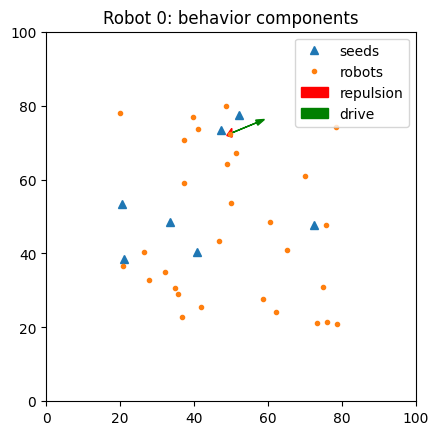

In [ ]:
def behavior(
    robot_index: int,
    robot_positions: np.ndarray,
    sensing_radius: float,
):
    # Local sensing
    scan = sensor(robot_positions, seed_coords, sensing_radius)[robot_index]
    neighbors = scan["robots"]
    seeds = scan["seeds"]

    # Repulsion from nearby neighbors
    repulsion_vector = np.zeros(2)
    for neighbor in neighbors:
        distance = neighbor["distance"]
        if distance <= 1e-6:
            continue
        if distance < sensing_radius / 2:
            repulsion_vector -= (neighbor["vector"] / distance) * (1.0 / distance**2)
    repulsion_vector *= 5.0

    # Attraction/drive using nearest and farthest seeds
    if len(seeds) >= 2:
        sorted_seeds = sorted(seeds, key=lambda s: s["distance"])
        closest_seed = sorted_seeds[0]
        farthest_seed = sorted_seeds[-1]
        drive_vector = (
            (farthest_seed["vector"] / max(farthest_seed["distance"], 1e-9)) -
            (closest_seed["vector"] / max(closest_seed["distance"], 1e-9))
        )
        n = np.linalg.norm(drive_vector)
        if n > 1e-6:
            drive_vector /= n
    else:
        drive_vector = np.zeros(2)

    return neighbors, seeds, repulsion_vector, drive_vector

# Demonstration: decompose for one robot
(
    local_neighbors,
    local_seeds,
    repulsion_vector,
    drive_vector
) = behavior(active_robot_index, robot_coords, SENSING_RADIUS)

print("Local neighbors:", len(local_neighbors))
print("Local seeds:", len(local_seeds))
print("Repulsion vector:", repulsion_vector, "Drive vector:", drive_vector)

# Visualization
fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0])
ax.set_ylim(0, FIELD_SIZE[1])
ax.set_aspect("equal")
ax.set_title(f"Robot {active_robot_index}: behavior components")
ax.plot(seed_coords[:, 0], seed_coords[:, 1], '^', linestyle='None', label="seeds")
ax.plot(robot_coords[:, 0], robot_coords[:, 1], 'o', markersize=3, label="robots")

ARROW_SCALE = 10.0
ax.arrow(
    robot_coords[active_robot_index, 0],
    robot_coords[active_robot_index, 1],
    repulsion_vector[0] * ARROW_SCALE,
    repulsion_vector[1] * ARROW_SCALE,
    head_width=1.5,
    length_includes_head=True,
    color="red",
    label="repulsion"
)
ax.arrow(
    robot_coords[active_robot_index, 0],
    robot_coords[active_robot_index, 1],
    drive_vector[0] * ARROW_SCALE,
    drive_vector[1] * ARROW_SCALE,
    head_width=1.5,
    length_includes_head=True,
    color="green",
    label="drive"
)
ax.legend()
plt.show()

## One-step update (no messaging)

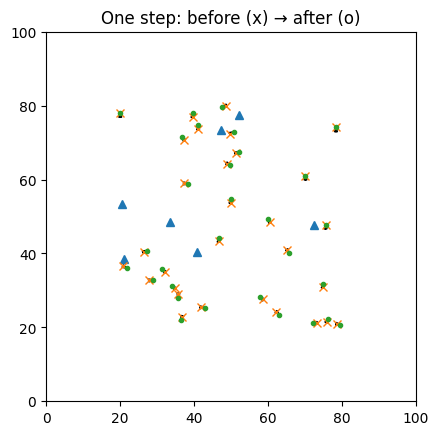

In [7]:
def one_step(robot_positions: np.ndarray):
    scans = sensor(robot_positions, seed_coords, SENSING_RADIUS)

    for i in range(len(robot_positions)):
        neighbors = scans[i]["robots"][:]  # local neighbors
        seeds     = scans[i]["seeds"][:]   # local seeds

        # Forces
        repulsion = np.zeros(2)
        for nb in neighbors:
            d = nb['distance']
            if d <= 1e-6:
                continue
            if d < SENSING_RADIUS/2:
                repulsion -= (nb['vector'] / d) * (1.0 / d**2)
        repulsion *= 5.0

        if len(seeds) >= 2:
            seeds_sorted = sorted(seeds, key=lambda s: s['distance'])
            near, far = seeds_sorted[0], seeds_sorted[-1]
            drive = (far['vector'] / max(far['distance'], 1e-9)) - (near['vector'] / max(near['distance'], 1e-9))
            n = np.linalg.norm(drive)
            if n > 1e-6:
                drive /= n
        else:
            drive = np.zeros(2)

        move = drive + repulsion
        if np.linalg.norm(move) > 1e-2:
            step = move / np.linalg.norm(move) * SPEED
            robot_positions[i] = robot_positions[i] + step
            robot_positions[i, 0] = np.clip(robot_positions[i, 0], 0, FIELD_SIZE[0])
            robot_positions[i, 1] = np.clip(robot_positions[i, 1], 0, FIELD_SIZE[1])

pos_before = robot_coords.copy()
one_step(robot_coords)
pos_after = robot_coords.copy()

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0]); ax.set_ylim(0, FIELD_SIZE[1]); ax.set_aspect("equal")
ax.set_title("One step: before (x) → after (o)")
ax.plot(seed_coords[:,0], seed_coords[:,1], '^', linestyle='None')
ax.plot(pos_before[:,0], pos_before[:,1], 'x')
ax.plot(pos_after[:,0], pos_after[:,1], 'o', markersize=3)
for i in range(len(pos_before)):
    dx, dy = pos_after[i] - pos_before[i]
    ax.arrow(pos_before[i,0], pos_before[i,1], dx, dy, head_width=0.8, length_includes_head=True)
plt.show()

## Voronoi Drawing

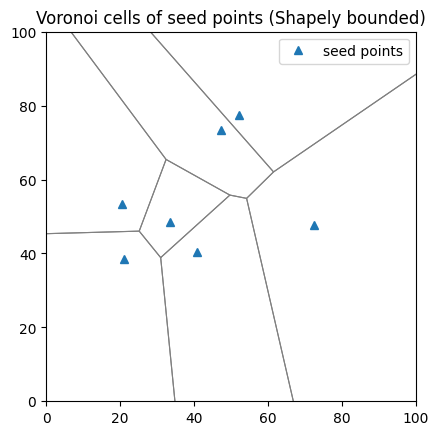

In [8]:
def draw_voronoi(points: np.ndarray, width: int, height: int, ax, artists_store: list):
    # clear old artists
    for artist in artists_store:
        artist.remove()
    artists_store.clear()

    if len(points) < 2:
        return

    # build bounded diagram
    bbox = box(0, 0, width, height)
    mp = MultiPoint([tuple(p) for p in points])
    cells = voronoi_diagram(mp, envelope=bbox, edges=False)  # polygons, already clipped

    # draw polygons
    for poly in cells.geoms:
        x, y = poly.exterior.xy
        line, = ax.plot(x, y, 'gray', lw=0.8, zorder=0)
        artists_store.append(line)
        # optional: draw holes if present
        for ring in poly.interiors:
            xi, yi = ring.xy
            hole, = ax.plot(xi, yi, 'gray', lw=0.6, zorder=0)
            artists_store.append(hole)

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0])
ax.set_ylim(0, FIELD_SIZE[1])
ax.set_aspect("equal")
ax.set_title("Voronoi cells of seed points (Shapely bounded)")
ax.plot(seed_coords[:, 0], seed_coords[:, 1], '^', label='seed points')

voronoi_artists = []
draw_voronoi(seed_coords, FIELD_SIZE[0], FIELD_SIZE[1], ax, voronoi_artists)
ax.legend()
plt.show()

In [9]:
PATHS: List[list] = [[robot_coords[i].copy()] for i in range(NUM_ROBOTS)]

fig, ax = plt.subplots()
ax.set_xlim(0, FIELD_SIZE[0]); ax.set_ylim(0, FIELD_SIZE[1]); ax.set_aspect("equal")
ax.set_title("Full run")
ax.set_xlabel("X"); ax.set_ylabel("Y")
ax.plot(seed_coords[:,0], seed_coords[:,1], '^', linestyle='None')

scatters = [ax.plot([], [], 'o', markersize=4)[0] for _ in range(NUM_ROBOTS)]
trails = [ax.plot([], [], '-', linewidth=1, alpha=0.25)[0] for _ in range(NUM_ROBOTS)]
voronoi_lines = []
frame_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, fontsize=10,
                     verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

def update(frame):
    # Local scans only
    scans = sensor(robot_coords, seed_coords, SENSING_RADIUS)

    # Update robots
    for i in range(len(robot_coords)):
        neighbors = scans[i]["robots"][:]
        seeds     = scans[i]["seeds"][:]

        # Forces
        repulsion = np.zeros(2)
        for nb in neighbors:
            d = nb['distance']
            if d <= 1e-6:
                continue
            if d < SENSING_RADIUS/2:
                repulsion -= (nb['vector'] / d) * (1.0 / d**2)
        repulsion *= 5.0

        if len(seeds) >= 2:
            seeds_sorted = sorted(seeds, key=lambda s: s['distance'])
            near, far = seeds_sorted[0], seeds_sorted[-1]
            drive = (far['vector'] / max(far['distance'], 1e-9)) - (near['vector'] / max(near['distance'], 1e-9))
            n = np.linalg.norm(drive)
            if n > 1e-6:
                drive /= n
        else:
            drive = np.zeros(2)

        move = drive + repulsion
        if np.linalg.norm(move) > 1e-2:
            step = move / np.linalg.norm(move) * SPEED
            robot_coords[i] = robot_coords[i] + step
            robot_coords[i, 0] = np.clip(robot_coords[i, 0], 0, FIELD_SIZE[0])
            robot_coords[i, 1] = np.clip(robot_coords[i, 1], 0, FIELD_SIZE[1])

    # Draw
    for i in range(NUM_ROBOTS):
        PATHS[i].append(robot_coords[i].copy())
        xs, ys = zip(*PATHS[i])
        scatters[i].set_data([xs[-1]], [ys[-1]])
        trails[i].set_data(xs, ys)

    # Voronoi overlay
    draw_voronoi(seed_coords, FIELD_SIZE[0], FIELD_SIZE[1], ax, voronoi_lines)
    frame_text.set_text(f"Frame: {frame+1}/{STEP_COUNT}")
    if frame == STEP_COUNT - 1:
        for t in trails:
            t.set_data([], [])
    return scatters + trails + voronoi_lines + [frame_text]

ani = FuncAnimation(fig, update, frames=STEP_COUNT, interval=ANIMATION_INTERVAL, blit=True, repeat=False)
plt.close(fig)
HTML(ani.to_jshtml())